In [1]:
from plantcv import plantcv as pcv
import numpy as np
import torch
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# n = 1
# img_path = f"./images/sized/{n}.jpg"
# img, _, _ = pcv.readimage(filename=img_path, mode='rgb')
# img.shape

In [2]:
# tt, _, _ = pcv.readimage(filename="./tt.png", mode="rgb")
# tt.shape

In [3]:
# mask_path = f"./images/mask/{n}.jpg"
# mask, _, _ = pcv.readimage(filename=mask_path, mode="gray")
# # black:0, white: 255
# mask[mask>0]=1
# mask=mask[:, :, np.newaxis]
# mask.shape

In [4]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader


class SegDataset(Dataset):
    def __init__(self, mask_dir, img_dir, transform=None, mask_transform=None):
        self.mask_dir = mask_dir
        self.img_dir = img_dir
        self.n_mask = len(os.listdir(self.mask_dir))
        self.n_img = len(os.listdir(self.img_dir))
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):     
        return min(self.n_img, self.n_mask)

    def __getitem__(self, idx):
        
        filename = os.listdir(self.img_dir)[idx]
        
        img_path = f"{self.img_dir}{filename}"
        img, _, _ = pcv.readimage(filename=img_path, mode='rgb')
        img = img/255
        """
        Normalization to be added
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        """
        # plantcv read returns image by Height x Width x Channels
        img = np.transpose(img, (2,0,1))
        # adjust image dimension to Channels x Height x Width
        
        mask_path = f"{self.mask_dir}{filename}"
        mask, _, _ = pcv.readimage(filename=mask_path, mode="gray")
        mask[mask>0]=1    # black:0, white: 255
        mask=mask[np.newaxis,:, :]
        
        if self.transform:
            image = self.transform(img)
        if self.mask_transform:
            label = self.mask_transform(mask)
        return img, mask

train_mask_dir = f"./images/train/mask/"
train_img_dir = f"./images/train/img/"
training_set = SegDataset(train_mask_dir, train_img_dir)
training_generator = DataLoader(training_set, batch_size=5, shuffle=True)

val_mask_dir = f"./images/validation/mask/"
val_img_dir = f"./images/validation/img/"
validation_set = SegDataset(val_mask_dir, val_img_dir)
validation_generator = DataLoader(validation_set, batch_size=2, shuffle=True)
    


In [5]:
# for x in iter(training_generator):
#     print("\n", type(x), len(x))
#     print("\n", type(x[0]), x[0].size())
#     print(x[0])
#     break

In [6]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

model = createDeepLabv3()


In [7]:
from sklearn.metrics import f1_score, roc_auc_score

# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Specify the evaluation metrics
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

In [8]:
import copy
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10
model.to(device)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [9]:
num_epochs = 1

for epoch in range(1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)
    
    train_epoch_loss = 0
    test_epoch_loss = 0
    
    for phase in ['Train', 'Test']:
        if phase == 'Train':
            model.train()  # Set model to training mode
            for sample in iter(training_generator):
                inputs = sample[0].to(device)
                inputs = inputs.to(torch.float32)
                masks = sample[1].to(device)
                masks = masks.to(torch.float32)

                optimizer.zero_grad()
#                 print(inputs.size(), masks.size())
#                 print(inputs.dtype, masks.dtype)
                
                outputs = model(inputs)
                loss = criterion(outputs['out'], masks)
                batch_loss = loss.item()
                
#                 y_pred = outputs['out'].data.cpu().numpy().ravel()
#                 y_true = masks.data.cpu().numpy().ravel()
#                 train_f1.append(f1_score(y_true > 0, y_pred > 0.1))
#                 train_auroc.append(roc_auc_score(y_true.astype('uint8'), y_pred))

                loss.backward()
                optimizer.step()
                train_epoch_loss += batch_loss
                print('{} Batch Loss: {:.4f}'.format(phase, batch_loss))
        
        else:
            model.eval()  # Set model to evaluate mode
            for sample in iter(validation_generator):
                inputs = sample[0].to(device)
                inputs = inputs.to(torch.float32)
                masks = sample[1].to(device)
                masks = masks.to(torch.float32)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs['out'], masks)
                batch_loss = loss.item()
                test_epoch_loss += batch_loss

#                 y_pred = outputs['out'].data.cpu().numpy().ravel()
#                 y_true = masks.data.cpu().numpy().ravel()
#                 test_f1.append(f1_score(y_true > 0, y_pred > 0.1))
#                 test_auroc.append(roc_auc_score(y_true.astype('uint8'), y_pred))
                print('{} Batch Loss: {:.4f}'.format(phase, batch_loss))
            
    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_epoch_loss:.4f} | Test Loss: {test_epoch_loss:.4f}")




Epoch 1/1
----------
Train Batch Loss: 1.3131
Train Batch Loss: 1.5926
Train Batch Loss: 1.0632
Train Batch Loss: 1.0588
Train Batch Loss: 0.8199
Train Batch Loss: 0.8711
Train Batch Loss: 0.9638
Train Batch Loss: 0.5358
Train Batch Loss: 0.8934
Train Batch Loss: 0.7189
Test Batch Loss: 0.3165
Test Batch Loss: 0.3743
Test Batch Loss: 0.5215
Test Batch Loss: 0.4162
Test Batch Loss: 0.3687
Epoch 1/2 | Train Loss: 9.8307 | Test Loss: 1.9972


In [37]:
for sample in iter(validation_generator):
    inputs = sample[0].to(device)
    inputs = inputs.to(torch.float32)
    break

outputs = model(inputs)
outputs = outputs["out"]
y_pred = outputs[1].detach().numpy()
y_pred = y_pred[0,:,:]
y_pred_m = y_pred.copy()


In [38]:
img = inputs[1].detach().numpy()
img = np.transpose(img, (1,2,0))

img.shape

(500, 500, 3)

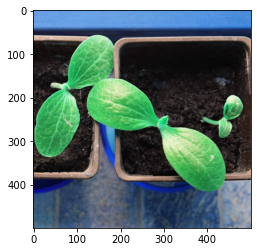

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(img)
plt.show()

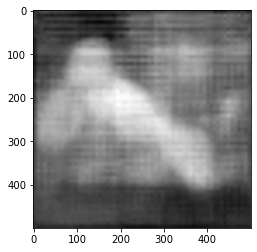

In [40]:
plt.imshow(y_pred_m*255, cmap="gray")
plt.show()